In [1]:
%pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 374.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [3]:
notebook_login()

In [6]:
dataset = load_dataset("beans")
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [8]:
dataset["train"][0]

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

In [9]:
labels = dataset["train"].unique("labels")
labels

[0, 1, 2]

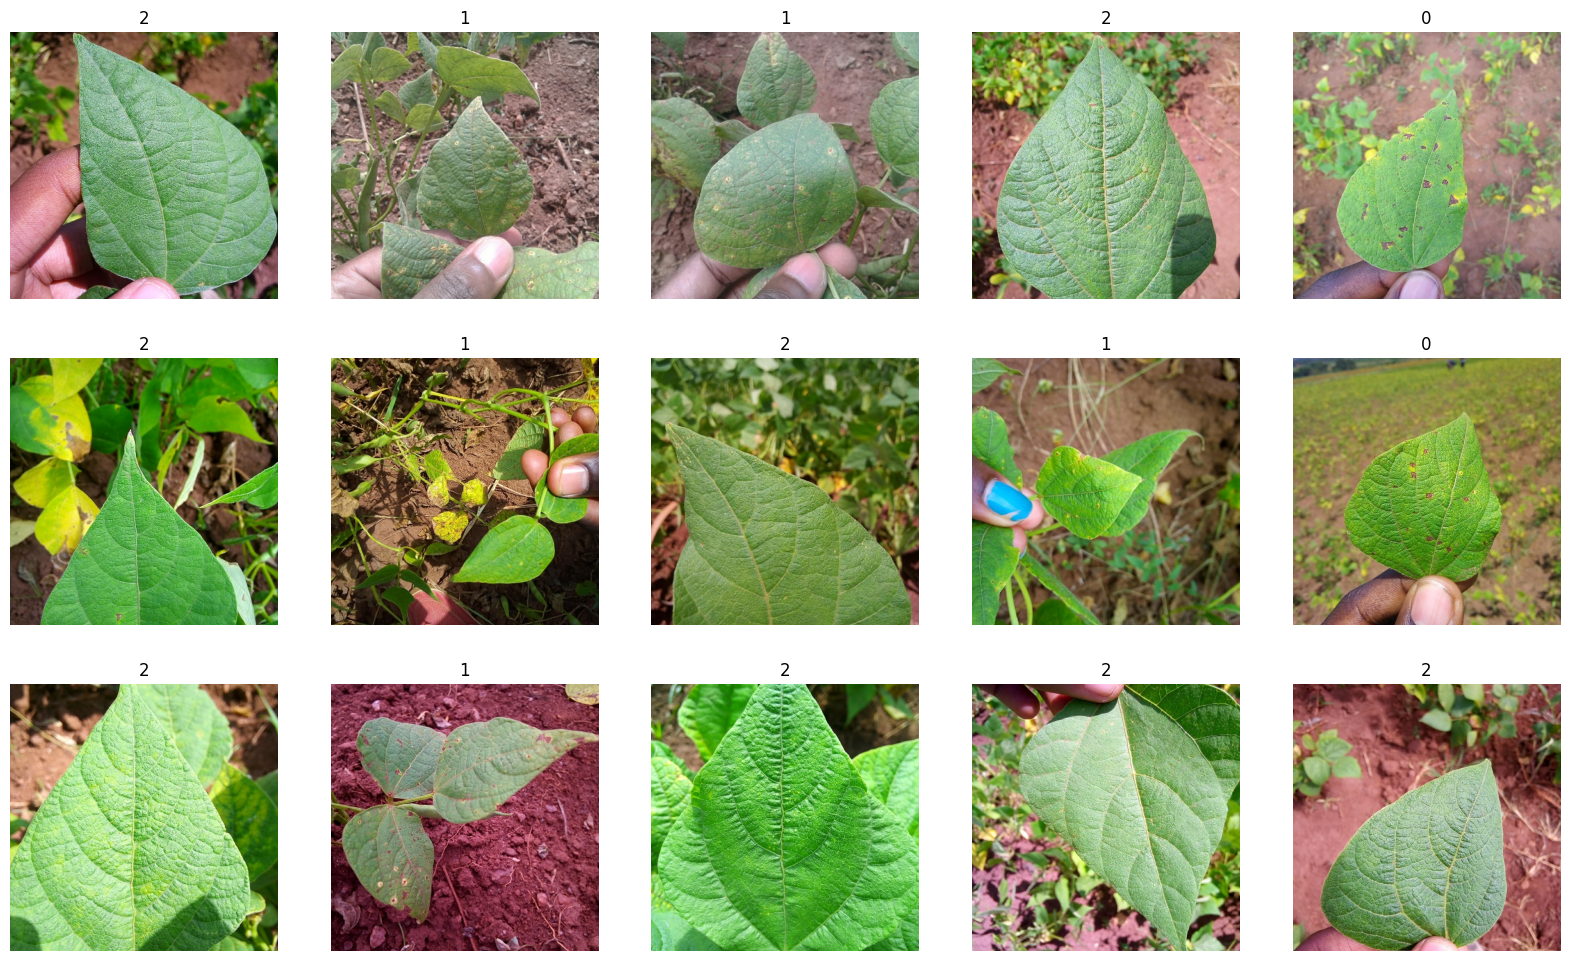

In [11]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['labels']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

In [12]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

our_dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 103
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 104
    })
})

In [13]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

In [14]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [16]:
processed_dataset = our_dataset.with_transform(transforms)

In [17]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [18]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

In [21]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(768,len(labels)),
    nn.ReLU(),
    nn.Linear(len(labels),len(labels)),
    nn.Softmax(dim=1)
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [23]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [24]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,975 | trainable_params = 2,319


In [27]:
from PIL import Image
import requests
from transformers import AutoImageProcessor, ViTModel # Import ViTModel instead of ViTForImageClassification
import torch

# Load and preprocess a single image
image_url = "https://cdn11.bigcommerce.com/s-q83qdckkjh/images/stencil/1280x1280/products/265/4712/Tendergreen-Bush-BeanBC2__21603.1706214562.jpg" # Replace with your image URL or local path
image = Image.open(requests.get(image_url, stream=True).raw)  # Load the image (adjust for local file as needed)

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Pass the image through the model
# Load the ViTModel for feature extraction
feature_extractor = ViTModel.from_pretrained('google/vit-base-patch16-224') # Load ViTModel

with torch.no_grad():
    outputs = feature_extractor(**inputs) # Get outputs from feature_extractor

# Extract the embedding array
embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Average across sequence dimension for a single vector

# Print the embedding array
print("Embedding Array:", embedding)
print("Embedding Shape:", embedding.shape)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding Array: [ 1.61280587e-01 -3.04567009e-01  2.01145694e-01 -6.74266294e-02
  7.69283175e-01 -6.84204102e-02  6.43524528e-01 -3.85823399e-01
  8.86093616e-01  7.27732241e-01  4.16219413e-01 -3.74421813e-02
  2.69905776e-01  3.19528013e-01 -3.68536055e-01  1.38337266e+00
  8.79466176e-01 -9.29566100e-02 -6.10432446e-01 -5.48836946e-01
 -1.03248537e+00  4.81403708e-01 -1.20984182e-01 -8.92069757e-01
  1.51258290e-01  2.16726027e-02 -7.30485559e-01  2.66893834e-01
 -4.14863586e-01 -3.03830206e-01 -8.36557865e-01 -1.30245137e+00
  5.80407500e-01  8.11437845e-01 -4.22692895e-02  1.14133760e-01
  6.79686546e-01 -3.34854424e-01 -4.10059750e-01  4.33047175e-01
  5.89128256e-01 -6.23514652e-01 -5.16934752e-01 -4.75864083e-01
  4.15388703e-01  9.05674100e-01 -3.88469726e-01  1.75613552e-01
 -1.20291519e+00 -1.12106562e+00 -5.83126605e-01 -2.18220904e-01
  6.52842939e-01  8.16074669e-01 -3.26457500e-01 -4.88426164e-03
 -1.12899644e-02 -6.50852501e-01 -3.48408192e-01 -3.09065147e-03
  2.2410